In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert

In [2]:
df = pd.read_csv('detrend_for_testing.csv')

In [3]:
new_column_names = {
    'Unnamed: 0': 'date',
    '0': 'detrend'
}

In [4]:
df = df.rename(columns=new_column_names)

In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [6]:
datetime_index = pd.DatetimeIndex(df.index)
reference_time = datetime_index[0]
df['sec'] = (datetime_index - reference_time).total_seconds()

In [7]:
df

,detrend,sec
date,,
2018-12-15 14:04:00,6.202159,0.0
2018-12-15 14:05:00,3.296165,60.0
2018-12-15 14:06:00,-1.608754,120.0
2018-12-15 14:07:00,-6.520289,180.0
2018-12-15 14:08:00,-11.438440,240.0
...,...,...
2018-12-15 22:25:00,-90.408889,30060.0
2018-12-15 22:26:00,-98.682678,30120.0
2018-12-15 22:27:00,-100.987008,30180.0


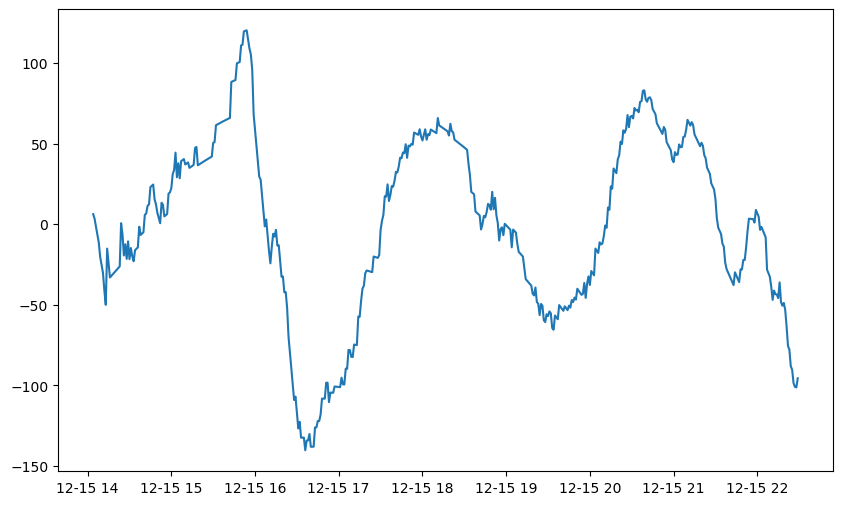

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['detrend'])
plt.show()

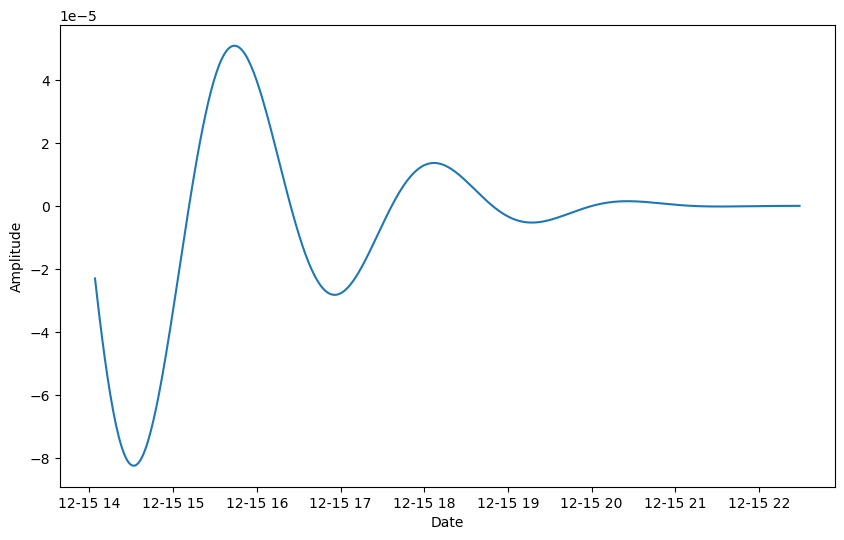

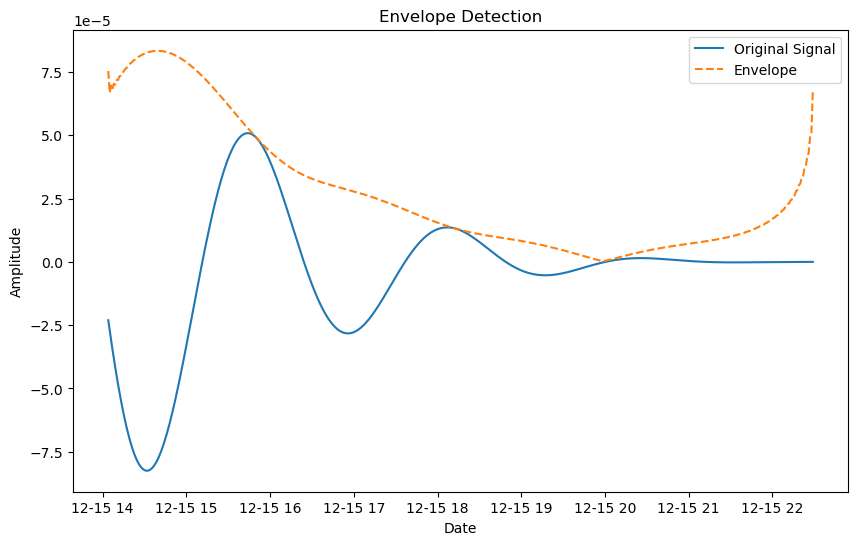

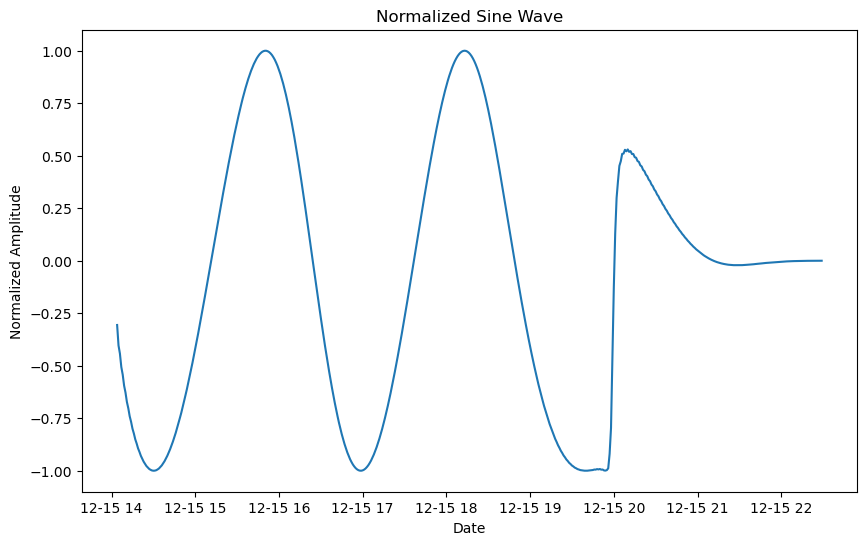

In [16]:
fs = 1/60
#fs=1000
low=2.4
high=2.5
# Design a band-pass filter
lowcut  = 1/(3600*high)  # Lower frequency bound (in Hz)
highcut = 1/(3600*low)  # Upper frequency bound (in Hz)
order = 4  # Filter order

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Apply the band-pass filter to the signal
filtered_signal = bandpass_filter(df['detrend'], lowcut, highcut, fs, order)

plt.figure(figsize=(10, 6))
plt.plot(df.index,filtered_signal)
plt.xlabel('Date')
plt.ylabel('Amplitude')
plt.show()

analytic_signal = hilbert(filtered_signal)
amplitude_envelope = np.abs(analytic_signal)

plt.figure(figsize=(10, 6))
plt.plot(df.index, filtered_signal, label='Original Signal')
plt.plot(df.index, amplitude_envelope, label='Envelope', linestyle='--')
plt.title('Envelope Detection')
plt.xlabel('Date')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

normalized_signal = filtered_signal / amplitude_envelope

plt.figure(figsize=(10, 6))
plt.plot(df.index, normalized_signal)
plt.title('Normalized Sine Wave')
plt.xlabel('Date')
plt.ylabel('Normalized Amplitude')
plt.show()

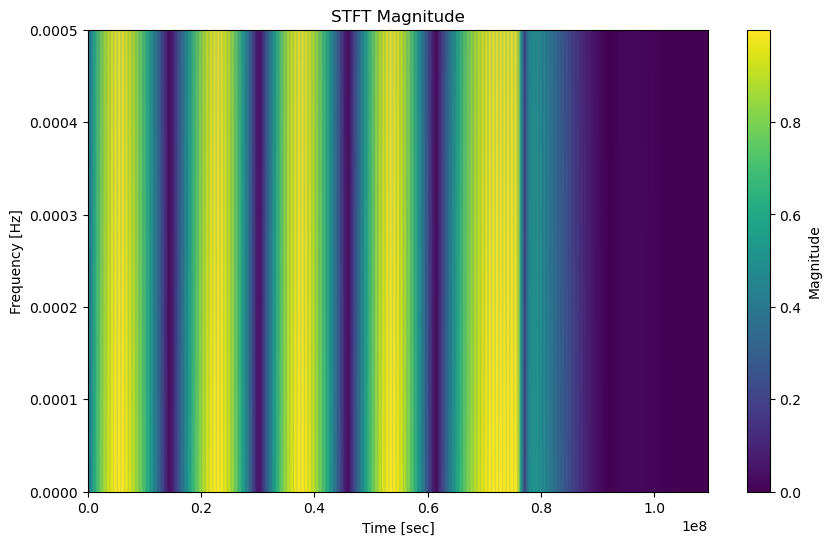

In [34]:
f, t_stft, Zxx  = stft(normalized_signal, fs=fs, nperseg=5)
t_stft_datetime = [datetime_index[0] + pd.Timedelta(seconds=t_point) for t_point in t_stft]
t_stft_sec      = t_stft * 3600
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_stft_sec, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0, 0.0005])
plt.colorbar(label='Magnitude')
plt.show()

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00333333
 0.         0.         0.         0.         0. 

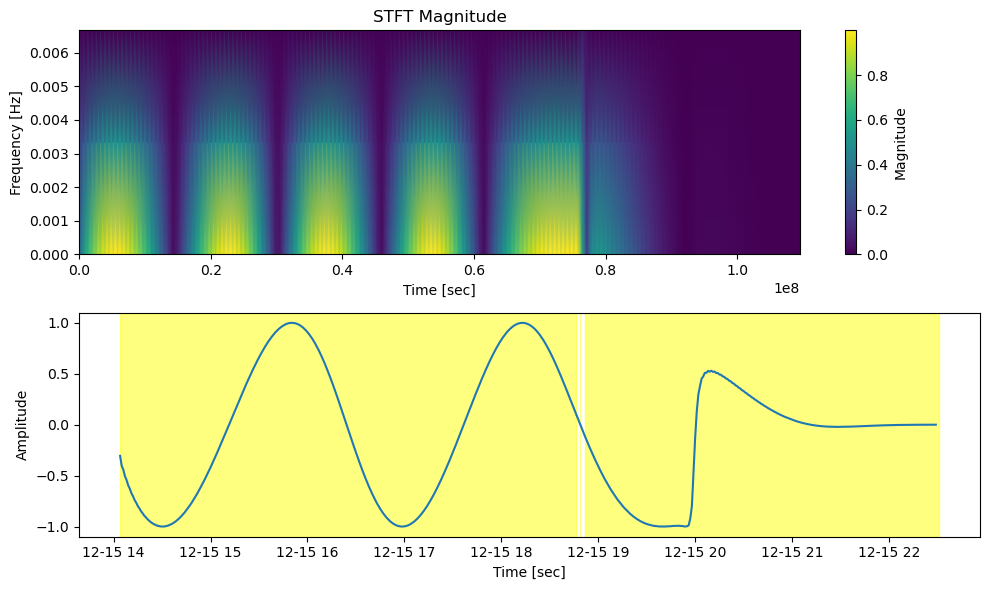

In [35]:
magnitude = np.abs(Zxx)
dominant_frequency = f[np.argmax(magnitude, axis=0)]
print(dominant_frequency)
print(magnitude)
threshold = 0.00027777  # Threshold for frequency variation
segment_indices = []

current_segment = []
previous_freq = None

for i, freq in enumerate(dominant_frequency):
    if previous_freq is None or abs(freq - previous_freq) < threshold:
        current_segment.append(i)
    else:
        if len(current_segment) > 0:
            segment_indices.append(current_segment)
        current_segment = [i]
    previous_freq = freq

# Append the last segment
if len(current_segment) > 0:
    segment_indices.append(current_segment)

time_ranges = [(t_stft_datetime[seg[0]], t_stft_datetime[seg[-1]]) for seg in segment_indices]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.pcolormesh(t_stft_sec, f, magnitude, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.ylim([0, 0.1])
#plt.xlim([7,8])
plt.colorbar(label='Magnitude')
#plt.axvspan(start_time, end_time, color='red', alpha=0.2)

plt.subplot(2, 1, 2)
plt.plot(df.index, normalized_signal, label='Original Signal')
for start, end in time_ranges:
    plt.axvspan(start, end, color='yellow', alpha=0.5, label='Constant Period Section')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
#plt.xlim([7,8])

plt.tight_layout()
plt.show()